In [2]:
from urlparse import urlparse
import re
import urllib2
import urllib
from xml.dom import minidom
import csv
import pygeoip

In [3]:
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]

nf=-1

In [4]:
def Tokenise(url):

        if url=='':
            return [0,0,0]
        token_word=re.split('\W+',url)
        print token_word
        no_ele=sum_len=largest=0
        for ele in token_word:
                l=len(ele)
                sum_len+=l
                if l>0:                                        ## for empty element exclusion in average length
                        no_ele+=1
                if largest<l:
                        largest=l
        try:
            return [float(sum_len)/no_ele,no_ele,largest]
        except:
            return [0,no_ele,largest]

In [5]:
def find_ele_with_attribute(dom,ele,attribute):
    for subelement in dom.getElementsByTagName(ele):
        if subelement.hasAttribute(attribute):
            return subelement.attributes[attribute].value
    return nf

In [6]:
def sitepopularity(host):

        xmlpath='http://data.alexa.com/data?cli=10&dat=snbamz&url='+host
        #print xmlpath
        try:
            xml= urllib2.urlopen(xmlpath)
            dom =minidom.parse(xml)
            rank_host=find_ele_with_attribute(dom,'REACH','RANK')
            #country=find_ele_with_attribute(dom,'REACH','RANK')
            rank_country=find_ele_with_attribute(dom,'COUNTRY','RANK')
            return [rank_host,rank_country]

        except:
            return [nf,nf]

In [7]:
def Security_sensitive(tokens_words):

    sec_sen_words=['confirm', 'account', 'banking', 'secure', 'ebayisapi', 'webscr', 'login', 'signin']
    cnt=0
    for ele in sec_sen_words:
        if(ele in tokens_words):
            cnt+=1;

    return cnt

In [8]:
def exe_in_url(url):
    if url.find('.exe')!=-1:
        return 1
    return 0

In [9]:
def Check_IPaddress(tokens_words):

    cnt=0;
    for ele in tokens_words:
        if unicode(ele).isnumeric():
            cnt+=1
        else:
            if cnt>=4 :
                return 1
            else:
                cnt=0;
    if cnt>=4:
        return 1
    return 0


# This function is not used currently

In [10]:
def getASN(host):
    try:
        g = pygeoip.GeoIP('GeoIPASNum.dat')
        asn=int(g.org_by_name(host).split()[0][2:])
        return asn
    except:
        return  nf

# This function is not used currently

In [11]:
def web_content_features(url):
    wfeatures={}
    total_cnt=0
    try:        
        source_code = str(opener.open(url))
        #print source_code[:500]

        wfeatures['src_html_cnt']=source_code.count('<html')
        wfeatures['src_hlink_cnt']=source_code.count('<a href=')
        wfeatures['src_iframe_cnt']=source_code.count('<iframe')
        #suspicioussrc_ javascript functions count

        wfeatures['src_eval_cnt']=source_code.count('eval(')
        wfeatures['src_escape_cnt']=source_code.count('escape(')
        wfeatures['src_link_cnt']=source_code.count('link(')
        wfeatures['src_underescape_cnt']=source_code.count('underescape(')
        wfeatures['src_exec_cnt']=source_code.count('exec(')
        wfeatures['src_search_cnt']=source_code.count('search(')
        
        for key in wfeatures:
            if(key!='src_html_cnt' and key!='src_hlink_cnt' and key!='src_iframe_cnt'):
                total_cnt+=wfeatures[key]
        wfeatures['src_total_jfun_cnt']=total_cnt
    
    except Exception, e:
        print "Error"+str(e)+" in downloading page "+url 
        default_val=nf
        
        wfeatures['src_html_cnt']=default_val
        wfeatures['src_hlink_cnt']=default_val
        wfeatures['src_iframe_cnt']=default_val
        wfeatures['src_eval_cnt']=default_val
        wfeatures['src_escape_cnt']=default_val
        wfeatures['src_link_cnt']=default_val
        wfeatures['src_underescape_cnt']=default_val
        wfeatures['src_exec_cnt']=default_val
        wfeatures['src_search_cnt']=default_val
        wfeatures['src_total_jfun_cnt']=default_val    
    
    return wfeatures

In [12]:
def safebrowsing(url):
    api_key = "ABQIAAAA8C6Tfr7tocAe04vXo5uYqRTEYoRzLFR0-nQ3fRl5qJUqcubbrw"
    name = "URL_check"
    ver = "1.0"

    req = {}
    req["client"] = name
    req["apikey"] = api_key
    req["appver"] = ver
    req["pver"] = "3.0"
    req["url"] = url #change to check type of url

    try:
        params = urllib.urlencode(req)
        req_url = "https://sb-ssl.google.com/safebrowsing/api/lookup?"+params
        res = urllib2.urlopen(req_url)
        # print res.code
        # print res.read()
        if res.code==204:
            # print "safe"
            return 0
        elif res.code==200:
            # print "The queried URL is either phishing, malware or both, see the response body for the specific type."
            return 1
        elif res.code==204:
            print "The requested URL is legitimate, no response body returned."
        elif res.code==400:
            print "Bad Request The HTTP request was not correctly formed."
        elif res.code==401:
            print "Not Authorized The apikey is not authorized"
        else:
            print "Service Unavailable The server cannot handle the request. Besides the normal server failures, it could also indicate that the client has been throttled by sending too many requests"
    except:
        return -1

In [13]:
Feature={}
url_input="http://stackoverflow.com/questions/34864672/in-jupyter-notebook-how-do-i-arrange-subroutines-in-order-to-write-a-project-ef"

In [14]:
url_input

'http://stackoverflow.com/questions/34864672/in-jupyter-notebook-how-do-i-arrange-subroutines-in-order-to-write-a-project-ef'

In [15]:
tokens_words=re.split('\W+',url_input)       #Extract bag of words stings delimited by (.,/,?,,=,-,_)
#print tokens_words,len(tokens_words)

#token_delimit1=re.split('[./?=-_]',url_input)
#print token_delimit1,len(token_delimit1)

obj=urlparse(url_input)
host=obj.netloc
path=obj.path

Feature['URL']=url_input

Feature['rank_host'],Feature['rank_country'] =sitepopularity(host)

Feature['host']=obj.netloc
Feature['path']=obj.path

Feature['Length_of_url']=len(url_input)
Feature['Length_of_host']=len(host)
Feature['No_of_dots']=url_input.count('.')

Feature['avg_token_length'],Feature['token_count'],Feature['largest_token'] = Tokenise(url_input)
Feature['avg_domain_token_length'],Feature['domain_token_count'],Feature['largest_domain'] = Tokenise(host)
Feature['avg_path_token'],Feature['path_token_count'],Feature['largest_path'] = Tokenise(path)

Feature['sec_sen_word_cnt'] = Security_sensitive(tokens_words)
Feature['IPaddress_presence'] = Check_IPaddress(tokens_words)

# print host
# print getASN(host)
# Feature['exe_in_url']=exe_in_url(url_input)
#Feature['ASNno']=getASN(host)
Feature['safebrowsing']=safebrowsing(url_input)

['http', 'stackoverflow', 'com', 'questions', '34864672', 'in', 'jupyter', 'notebook', 'how', 'do', 'i', 'arrange', 'subroutines', 'in', 'order', 'to', 'write', 'a', 'project', 'ef']
['stackoverflow', 'com']
['', 'questions', '34864672', 'in', 'jupyter', 'notebook', 'how', 'do', 'i', 'arrange', 'subroutines', 'in', 'order', 'to', 'write', 'a', 'project', 'ef']


In [16]:
Feature

{'IPaddress_presence': 0,
 'Length_of_host': 17,
 'Length_of_url': 123,
 'No_of_dots': 1,
 'URL': 'http://stackoverflow.com/questions/34864672/in-jupyter-notebook-how-do-i-arrange-subroutines-in-order-to-write-a-project-ef',
 'avg_domain_token_length': 8.0,
 'avg_path_token': 4.823529411764706,
 'avg_token_length': 5.1,
 'domain_token_count': 2,
 'host': 'stackoverflow.com',
 'largest_domain': 13,
 'largest_path': 11,
 'largest_token': 13,
 'path': '/questions/34864672/in-jupyter-notebook-how-do-i-arrange-subroutines-in-order-to-write-a-project-ef',
 'path_token_count': 17,
 'rank_country': u'49',
 'rank_host': u'52',
 'safebrowsing': 0,
 'sec_sen_word_cnt': 0,
 'token_count': 20}

In [16]:
sitepopularity(host)

[u'46', u'55']

In [1]:
import matplotlib

In [2]:
import pylab as pl

In [117]:
import pandas
import numpy

In [118]:
my_data= pandas.read_csv("./url_features.csv")

In [119]:
data = pandas.DataFrame.from_csv("./url_features.csv")

In [124]:
#data[data.malicious==2]
data.dtypes

rank_host                    int64
rank_country                 int64
ASNno                        int64
sec_sen_word_cnt             int64
avg_token_length           float64
No_of_dots                   int64
malicious                    int64
Length_of_url                int64
avg_path_token             float64
IPaddress_presence           int64
Length_of_host               int64
safebrowsing                 int64
URL                         object
host                        object
avg_domain_token_length    float64
path_token_count             int64
path                        object
largest_domain               int64
domain_token_count           int64
largest_path                 int64
largest_token                int64
dtype: object

In [113]:
data[data.URL=='http://google.com'].malicious

token_count
3    0
3    0
Name: malicious, dtype: int64

In [33]:
benign= len(data[data.malicious==0])

In [34]:
spam= len(data[data.malicious==1])

In [35]:
malware= len(data[data.malicious==2])

In [36]:
print spam,malware,benign

49 253 528


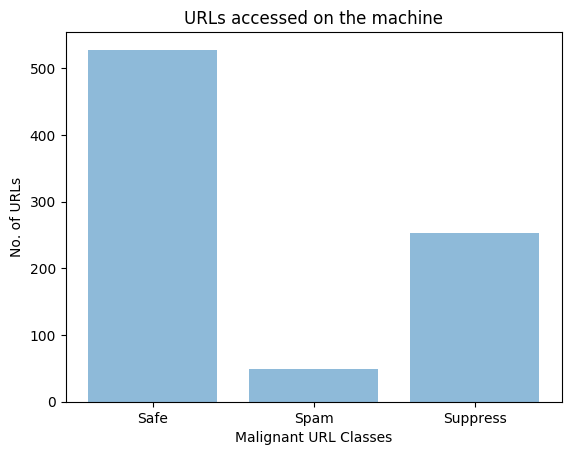

In [63]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Safe','Spam','Suppress')
y_pos = np.arange(len(objects))
performance = [benign,spam,malware]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('No. of URLs')
plt.xlabel('Malignant URL Classes')
plt.title('URLs accessed on the machine')
 
plt.show()

In [172]:
def append_result(outcome,output_dest):
    
    with open(output_dest,'a') as f:
        fieldnames = ['URL', 'malicious']
        w = csv.DictWriter(f,fieldnames=fieldnames)
        #w.writeheader()
        w.writerow({'URL' :outcome[0], 'malicious':outcome[1]})

In [185]:
import pandas
import numpy
def check_cache(input_url,output_dest):
    flag=-1
    data = pandas.DataFrame.from_csv(output_dest, index_col=None)
    print data
    if any(data.URL==input_url):
        flag=data[data.URL==input_url].malicious.values[0]
        
    #print flag
    return flag

In [187]:
import csv
flag=-1
url="http://abc.com"
flag= check_cache(url,'mycache.csv')
print flag
#append_result([url,flag],'mycache.csv')

                 URL  malicious
0  http://google.com          0
1      http://fb.com          0
2     http://abc.com         -1
-1
